In [25]:
#import di tutte le dipendenze e definizioni delle costanti
import pandas as pd
import numpy as np
from matplotlib import pyplot
from os import listdir
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score,confusion_matrix
from os.path import join
from torchvision.models import squeezenet1_1
from torch import nn,load
H=224
W=224
train_path="dataset_count_divided/train/"
test_path="dataset_count_divided/test/"

In [2]:
def get_mean(dataset):
    m = np.zeros(3)
    for sample in dataset:
        m+=sample[0].sum(1).sum(1).numpy() #accumuliamo la somma dei pixel canale per canale
    #dividiamo per il numero di immagini moltiplicato per il numero di pixel
    m=m/(len(dataset)*H*W) #H e W sono le dimensioni delle foto
    return m

def get_std(dataset):
    #fa la stessa cosa per calcolare la deviazione standard
    s = np.zeros(3)
    for sample in dataset:
        s+=((sample[0]-torch.Tensor(m).view(3,1,1))**2).sum(1).sum(1).numpy()
    s=np.sqrt(s/(len(dataset)*H*W))
    return s

In [5]:
class AverageValueMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.num = 0

    def add(self, value, num):
        self.sum += value*num
        self.num += num

    def value(self):
        try:
            return self.sum/self.num
        except:
            return None

In [7]:
def train_classifier(model, train_loader, test_loader, exp_name='experiment', lr=0.001, epochs=10, momentum=0.99, logdir='logs',decay=0):
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr, momentum=momentum,weight_decay=decay)
    #meters
    loss_meter = AverageValueMeter()
    acc_meter = AverageValueMeter()
    #writer
    writer = SummaryWriter(join(logdir, exp_name))
    #device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    #definiamo un dizionario contenente i loader di training e test
    loader = {
    'train' : train_loader,
    'test' : test_loader
    }
    #inizializziamo il global step
    global_step =0
    for e in range(epochs):
        #iteriamo tra due modalità: train e test
        for mode in ['train','test']:
            loss_meter.reset(); acc_meter.reset()
            model.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode=='train'): #abilitiamo i gradienti solo in training
                for i, batch in enumerate(loader[mode]):
                    x=batch[0].to(device) #"portiamoli sul device corretto"
                    y=batch[1].to(device)
                    output = model(x)
                    #aggiorniamo il global_step
                    #conterrà il numero di campioni visti durante il training
                    n = x.shape[0] #numero di elementi nel batch
                    global_step += n
                    l = criterion(output,y)
                    if mode=='train':
                        l.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                    acc = accuracy_score(y.to('cpu'),output.to('cpu').max(1)[1])
                    loss_meter.add(l.item(),n)
                    acc_meter.add(acc,n)
                    #loggiamo i risultati iterazione per iterazione solo durante il training
                    if mode=='train':
                        writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                        writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)
            #una volta finita l'epoca (sia nel caso di training che test, loggiamo le stime finali)
            writer.add_scalar('loss/' + mode, loss_meter.value(), global_step=global_step)
            writer.add_scalar('accuracy/' + mode, acc_meter.value(), global_step=global_step)
        if ((e+1)%50==0):
            torch.save(model.state_dict(),'%s-%d.pth'%(exp_name,e+1))
                

    #conserviamo i pesi del modello alla fine di un ciclo di training e test
    return model

In [9]:
#FUNZIONE CONFUSION MATRIX
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [10]:
def test_classifier(model, loader):
    device = "cpu" 
    model.to(device)
    predictions, labels = [], []
    for batch in loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        output = model(x)
        preds = output.to('cpu').max(1)[1].numpy()
        labs = y.to('cpu').numpy()
        predictions.extend(list(preds))
        labels.extend(list(labs))
    return np.array(predictions), np.array(labels)

In [3]:
#aggiungo 5 pixel per dimensione per poi rimuoverli nella transform train
transform = transforms.Compose([transforms.Resize((H+5,W+5)),transforms.ToTensor()]) 
train_set=torchvision.datasets.ImageFolder(train_path,transform=transform)
m=get_mean(train_set) #calcolo della media
print(m)
std=get_std(train_set) #caldolo della deviazione standard
print(std)


[0.47052186 0.46099029 0.44564317]
[0.27937052 0.27448315 0.27751098]


In [26]:
#effettuo un random crop di dimensioni 224x224 in modo da tagliare randomicamente ed eventualmente rimuovere la barra dell'orario
transform_train = transforms.Compose([transforms.Resize((H+5,W+5)),transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),transforms.RandomCrop((H,W)),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize(m,std)]) 
transform_test = transforms.Compose([transforms.Resize((H+5,W+5)),transforms.CenterCrop((H,W)),transforms.ToTensor(),transforms.Normalize(m,std)])
train_set=torchvision.datasets.ImageFolder(train_path,transform=transform_train) #legge automaticamente le immagini e le etichetta in base al nome della loro cartella
test_set=torchvision.datasets.ImageFolder(test_path,transform=transform_test)
loader_train=DataLoader(train_set, batch_size=128, num_workers=0,shuffle=True)
loader_test=DataLoader(test_set, batch_size=128, num_workers=0)

(array([0.05191116, 0.1598657 , 0.15650826, 0.15960744, 0.31404959,
        0.15805785]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Patch objects>)

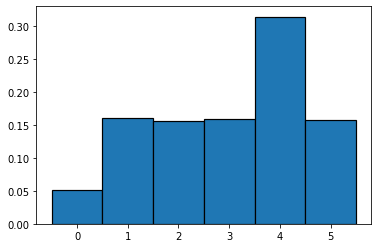

In [63]:
#plot che mostra la distribuzione delle classi
dataset=train_set.targets+test_set.targets
pyplot.hist(dataset,histtype="barstacked",bins=np.arange(0,7)-0.5,density=True,edgecolor='black', linewidth=1.2)

In [8]:
model = squeezenet1_1(pretrained=True)
### adattamento
model.classifier[1] = nn.Conv2d(512, 6, kernel_size=(1, 1), stride=(1, 1))
model.num_classes = 6
lr=0.00001
decay=0.1
name='model-jitter_datasetcount_divided_128_'+str('{0:.5f}'.format(lr))[2:]+"_decay"+str('{0:.2f}'.format(decay))[2:]
squeeze = train_classifier(model, loader_train, loader_test,, epochs=150,lr=lr, momentum=0.99,decay=decay) 

##### 

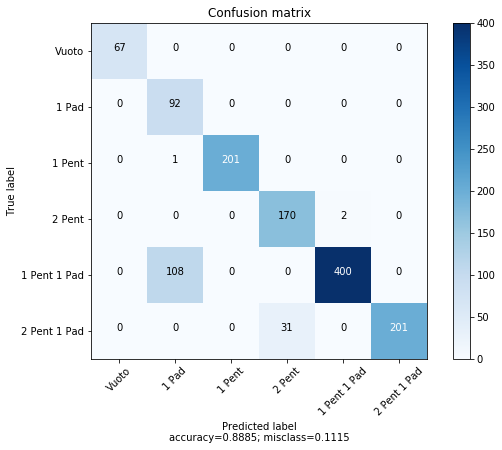

In [24]:
model = squeezenet1_1()
model.classifier[1] = nn.Conv2d(512, 6, kernel_size=(1, 1), stride=(1, 1))
model.num_classes = 6
model.load_state_dict(torch.load("model.pth")) #carico il modello per ottenere per ottenere le predizioni e calcolare la matrice
pred,labels=test_classifier(model,loader_test)
confusion_matrix(pred,labels)
plot_confusion_matrix(confusion_matrix(pred,labels),['Vuoto','1 Pad','1 Pent','2 Pent','1 Pent 1 Pad','2 Pent 1 Pad'],normalize=False)
